In [ ]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_core.messages import AnyMessage, AIMessage

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt, Command
from dotenv import load_dotenv
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage

: 

In [106]:
load_dotenv()

True

In [107]:
llm = ChatOpenAI(model="gpt-4.1-mini")

In [ ]:
from langgraph.graph.message import add_messages

class ChatState(TypedDict):

    messages: Annotated[list[BaseMessage], add_messages]

In [96]:
def chat_node(state: ChatState):

    decision = interrupt({
        "type": "approval",
        "reason": "Model is about to answer a user question.",
        "question": state["messages"][-1].content,
        "instruction": "Approve this question? yes/no"
    })
    
    if decision["approved"] == 'no':
        return {"messages": [AIMessage(content="Not approved.")]}

    else:
        response = llm.invoke(state["messages"])
        return {"messages": [response]}



In [109]:
# 3. Build the graph: START -> chat -> END
builder = StateGraph(ChatState)

builder.add_node("chat", chat_node)

builder.add_edge(START, "chat")
builder.add_edge("chat", END)

# Checkpointer is required for interrupts
checkpointer = MemorySaver()

# Compile the app
app = builder.compile(checkpointer=checkpointer)

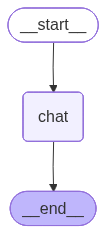

In [110]:
app

In [117]:
# Create a new thread id for this conversation
config = {"configurable": {"thread_id": '1234'}}

# ---- STEP 1: user asks a question ----
initial_input = {
    "messages": [
        ("user", "Explain gradient descent in very simple terms.")
    ]
}

# Invoke the graph for the first time
result = app.invoke(initial_input, config=config)

In [118]:
result

{'messages': [HumanMessage(content='Explain gradient descent in very simple terms.', additional_kwargs={}, response_metadata={}, id='d7bb9cc8-e132-4afe-a673-33d279309b83'),
  AIMessage(content='Not approved.', additional_kwargs={}, response_metadata={}, id='5b53bc94-8113-4b8e-8344-d9ebcf26d8a1'),
  HumanMessage(content='Explain gradient descent in very simple terms.', additional_kwargs={}, response_metadata={}, id='8b0dd45c-af99-497b-b665-9b25f0652427')],
 '__interrupt__': [Interrupt(value={'type': 'approval', 'reason': 'Model is about to answer a user question.', 'question': 'Explain gradient descent in very simple terms.', 'instruction': 'Approve this question? yes/no'}, id='8f970c37f92bf4a907ec29209ca75371')]}

In [119]:
message = result['__interrupt__'][0].value
message

{'type': 'approval',
 'reason': 'Model is about to answer a user question.',
 'question': 'Explain gradient descent in very simple terms.',
 'instruction': 'Approve this question? yes/no'}

In [120]:
user_input = input(f"\nBackend message - {message} \n Approve this question? (y/n): ")

In [121]:
# Resume the graph with the approval decision
final_result = app.invoke(
    Command(resume={"approved": user_input}),
    config=config,
)

In [ ]:
print(final_result["messages"][-1].content)

{'messages': [HumanMessage(content='Explain gradient descent in very simple terms.', additional_kwargs={}, response_metadata={}, id='d7bb9cc8-e132-4afe-a673-33d279309b83'), AIMessage(content='Not approved.', additional_kwargs={}, response_metadata={}, id='5b53bc94-8113-4b8e-8344-d9ebcf26d8a1'), HumanMessage(content='Explain gradient descent in very simple terms.', additional_kwargs={}, response_metadata={}, id='8b0dd45c-af99-497b-b665-9b25f0652427'), AIMessage(content='Sure! Imagine you\'re standing on a hill, and your goal is to reach the lowest point in the valley. However, it\'s foggy, so you can\'t see very far. To get down, you take small steps going downhill, always moving in the direction where the slope goes down the most. By repeating this—taking small steps downhill—you eventually reach the bottom.\n\nGradient descent is like that, but for finding the best solution in math or machine learning. Instead of a hill, you have a "function" to minimize (like an error or cost), and g